In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row

In [10]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")
# display(accidents_moon)

C:\Users\Hana\AppData\Local\Temp\ipykernel_30380\4041037844.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [11]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - dnevi brez luninih men

Preverila bom, če se ritmičnost nesreč, ki so se zgodile izven tistih dni, ko se menjajo lunine mene, razlikuje od ritmičnosti nesreč, ki so se zgodile v času menjanja luninih men.

In [15]:
# Maska za luno
accidents_moon['moon_phase'] = accidents_moon['moon_phase'].fillna('None')
moon_mask = (accidents_moon['moon_phase'] == 'None')

accidents_none = accidents_moon[moon_mask]
# display(accidents_none)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_none['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNone",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

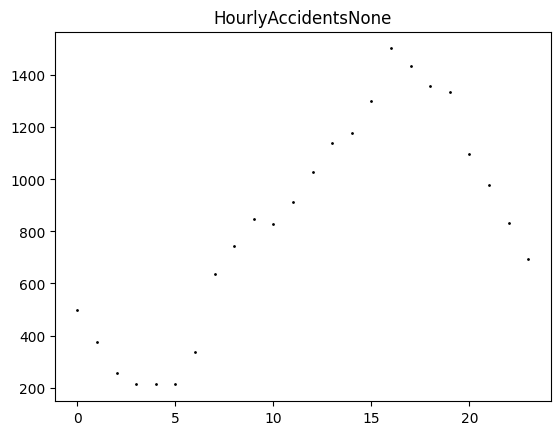

In [16]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNone"])

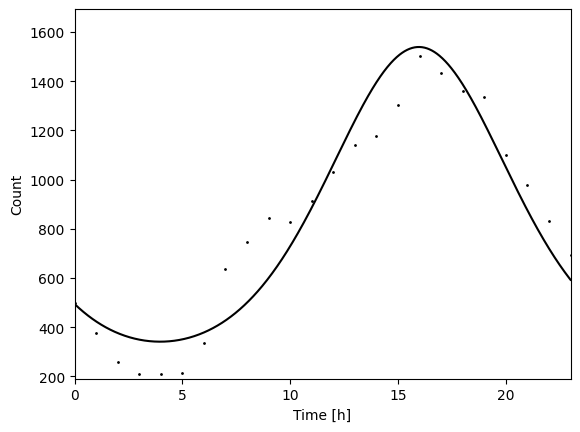

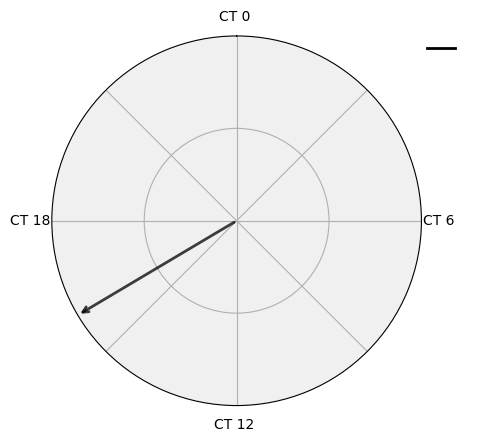

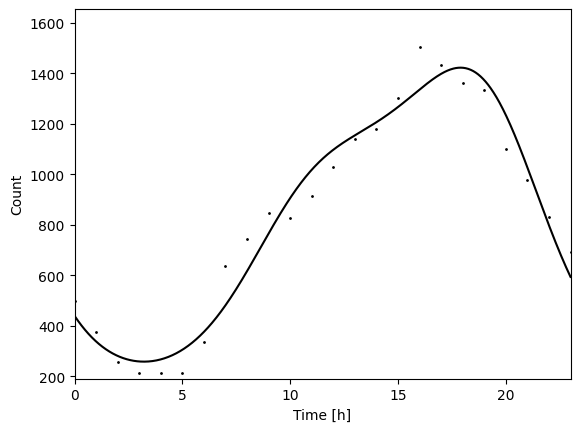

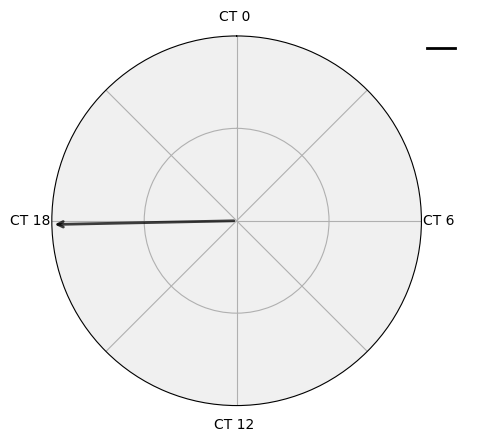

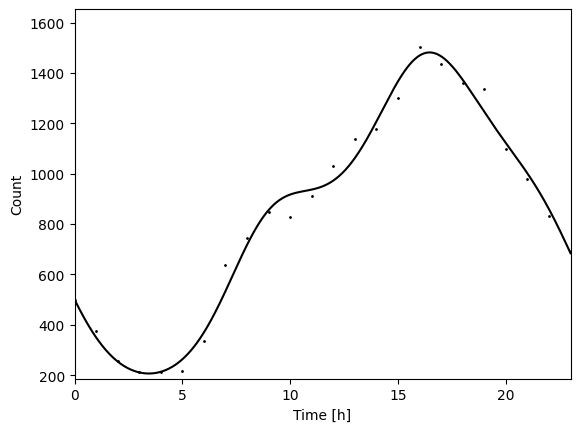

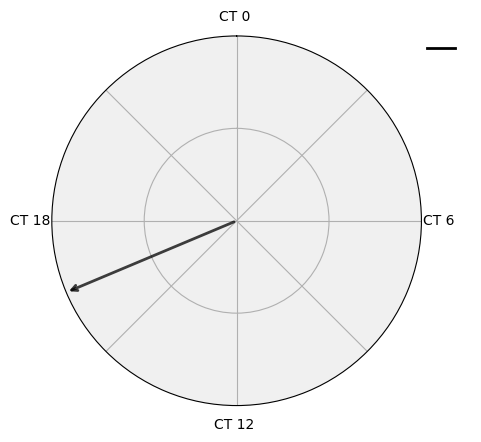

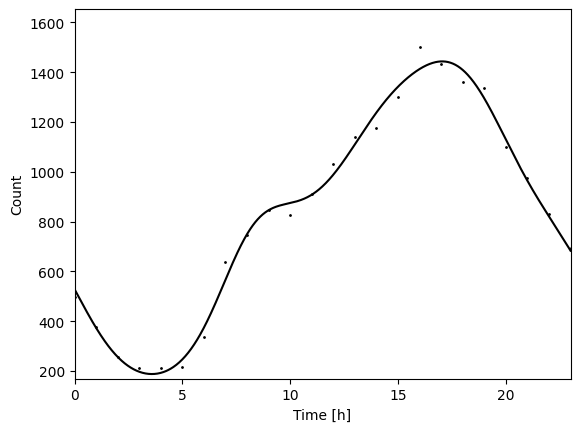

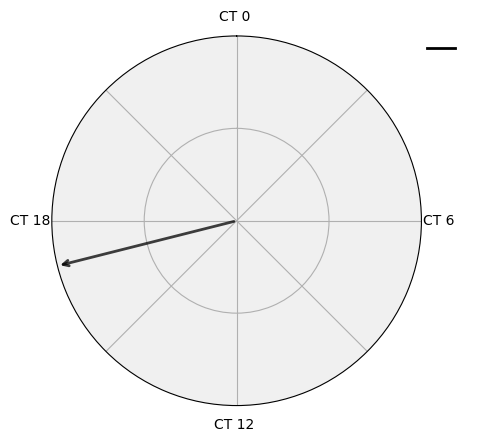

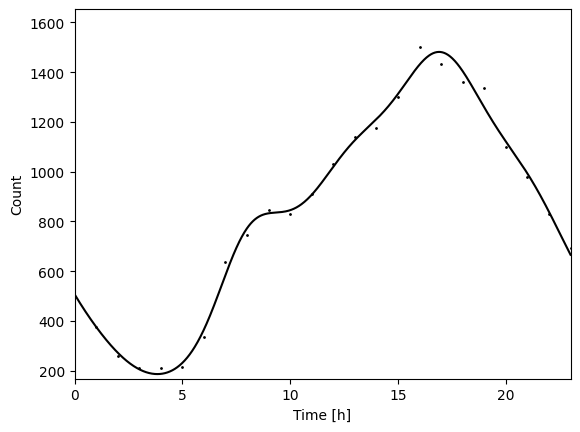

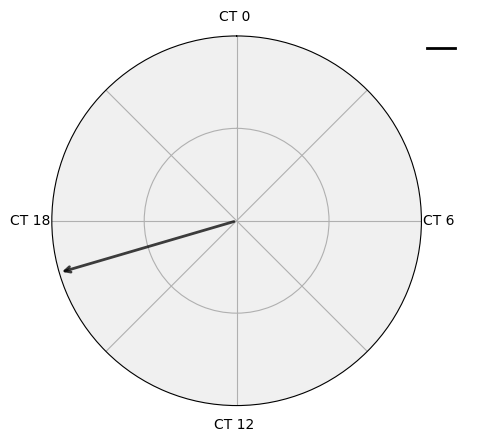

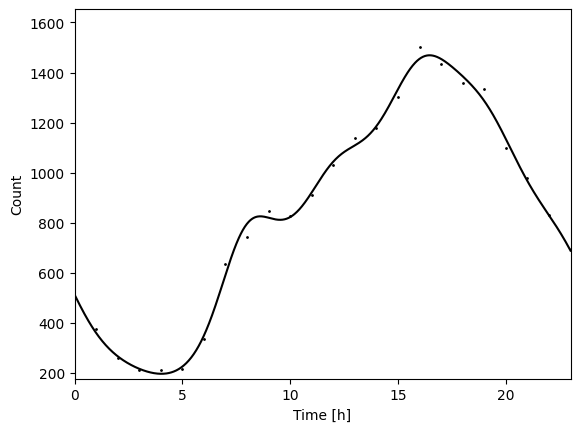

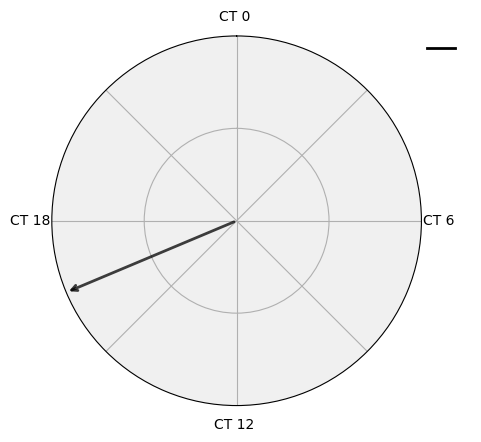

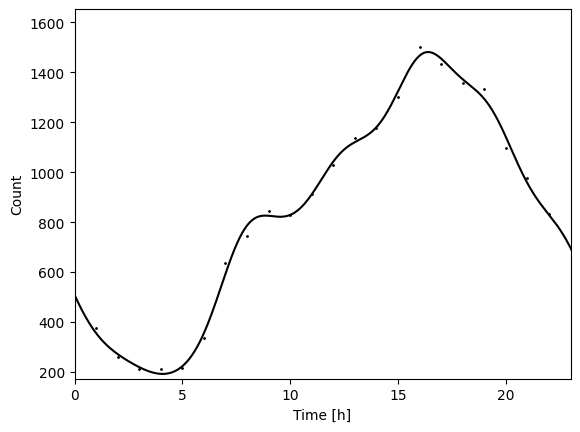

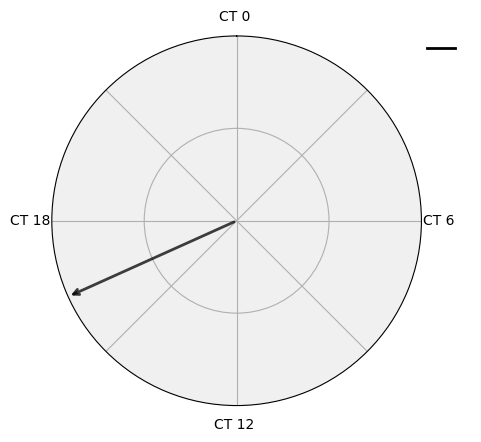

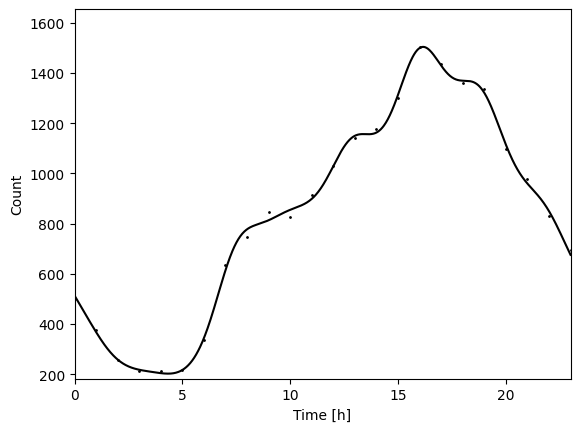

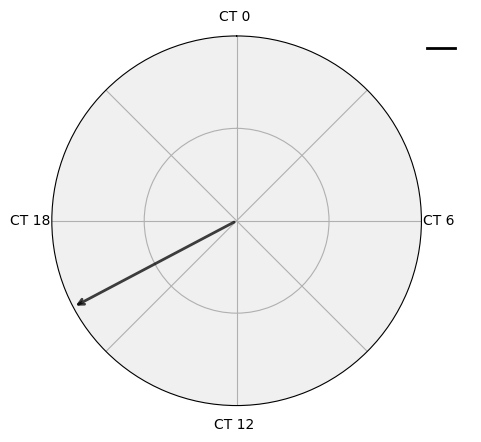

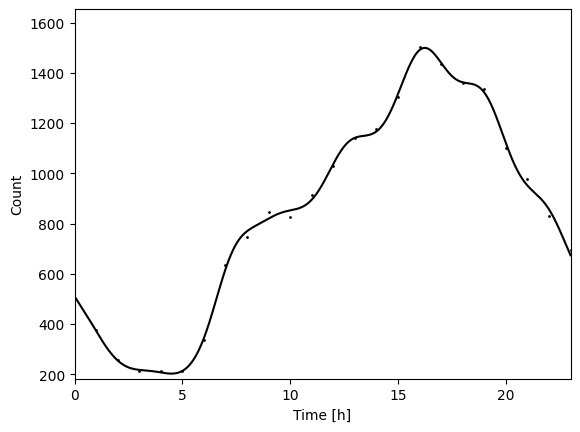

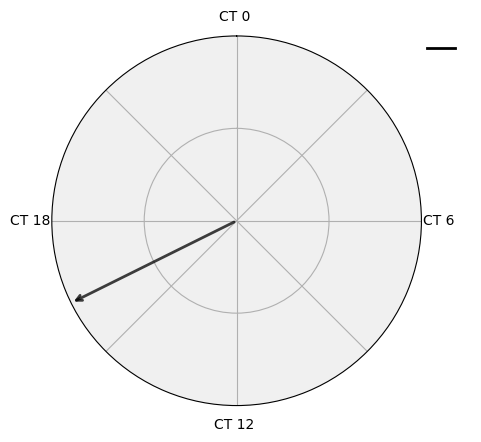

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


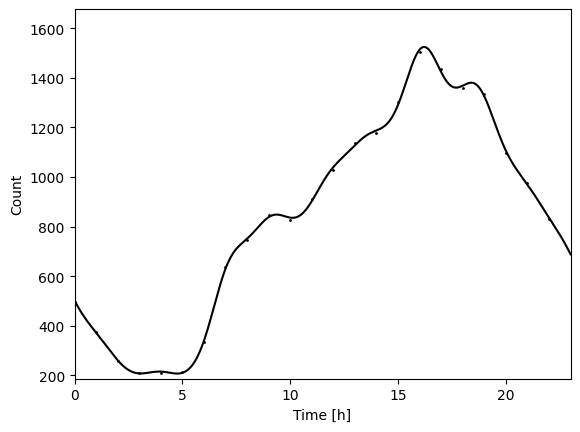

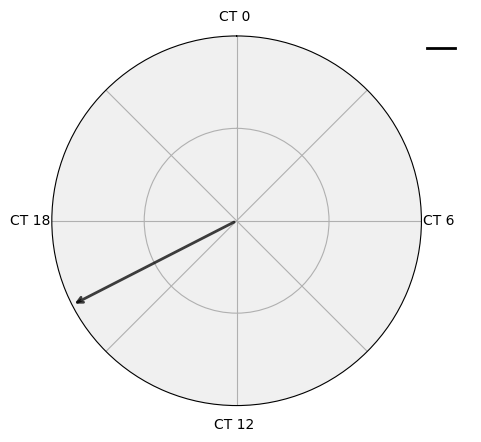

In [17]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNone', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [18]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNone,24.0,1.0,5.764624e-13,5.764624e-13,398443.215135,-152.264109,0.156179,598.984665,2.106974,940.386404,[15.951951951951951],[1539.362707859488],[3.987987987987988],[341.4049701647052]
1,HourlyAccidentsNone,24.0,2.0,8.547827e-17,9.497586e-17,158249.864122,-139.716498,0.225716,581.643052,1.591237,840.019760,[17.92192192192192],[1421.6422564513261],[3.219219219219219],[258.3767075318531]
2,HourlyAccidentsNone,24.0,3.0,1.226554e-21,1.533192e-21,50869.652487,-124.919306,0.307719,637.295372,1.968606,844.103955,[16.48048048048048],[1481.3856188530683],[3.4594594594594597],[206.80858353589093]
3,HourlyAccidentsNone,24.0,4.0,9.124159e-23,1.303451e-22,32645.595655,-119.089837,0.340025,627.649019,1.817658,815.759549,[17.057057057057058],[1443.4085679587413],[3.6036036036036037],[188.11798530797807]
4,HourlyAccidentsNone,24.0,5.0,2.344635e-23,3.907726e-23,24486.795617,-114.712501,0.364283,647.334319,1.855395,834.011806,[16.912912912912912],[1481.3461244430775],[3.843843843843844],[186.67748655925914]
5,HourlyAccidentsNone,24.0,6.0,2.962716e-24,7.406791e-24,15851.252949,-109.689118,0.392122,636.128845,1.968606,832.807327,[16.48048048048048],[1468.922818111284],"[4.036036036036036, 9.513513513513514]","[196.67848266830998, 811.6972264842053]"
6,HourlyAccidentsNone,24.0,7.0,1.435503e-23,2.871005e-23,12553.591580,-108.702728,0.397589,644.585289,1.993764,836.787864,[16.384384384384383],[1481.3731528782334],"[4.084084084084084, 9.513513513513514]","[192.20257567099287, 821.6780152644908]"
7,HourlyAccidentsNone,24.0,8.0,3.301679e-26,1.650839e-25,6016.963405,-99.448263,0.448875,650.695850,2.056658,853.106891,"[13.357357357357357, 16.144144144144143]","[1156.4722852128073, 1503.7351116796665]",[4.324324324324325],[202.41104089713713]
8,HourlyAccidentsNone,24.0,9.0,9.535432e-26,3.178477e-25,5714.977826,-98.044864,0.456653,648.142474,2.031500,850.926100,[16.24024024024024],[1499.0685740667498],[4.468468468468468],[202.7980153300888]
9,HourlyAccidentsNone,24.0,10.0,1.114696e-31,1.114696e-30,1435.231771,-80.435536,0.554240,658.517697,2.044079,866.293325,"[16.19219219219219, 18.4024024024024]","[1524.724545121889, 1380.7136037503888]","[3.075075075075075, 4.756756756756757, 10.0900...","[208.23363478574169, 207.7756279781649, 835.83..."


### Katero je najboljše število komponent

In [19]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNone,24.0,8.0,3.301679e-26,1.650839e-25,6016.963405,-99.448263,0.448875,650.69585,2.056658,853.106891,"[13.357357357357357, 16.144144144144143]","[1156.4722852128073, 1503.7351116796665]",[4.324324324324325],[202.41104089713713]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


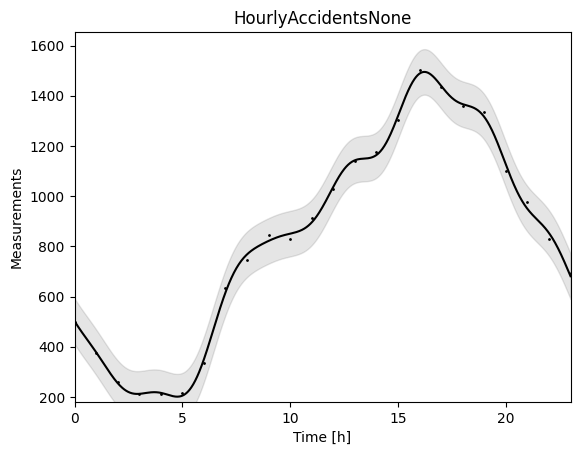

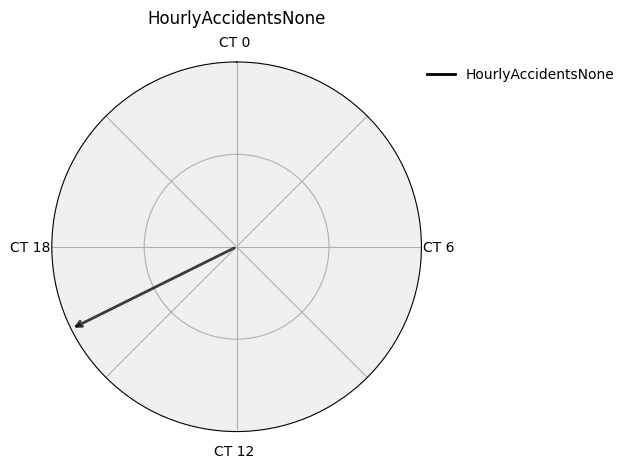

In [20]:
cosinor.plot_df_models(df_plot, df_best_model)